In [1]:
import os
import sys

os.chdir(os.path.dirname(sys.path[0]))

In [2]:
import pandas as pd

# Using the dataset found in ref 1
sun_data = {
    "p1": (pd.read_csv("solar/data/Plant_1_Generation_Data.csv"), pd.read_csv("solar/data/Plant_1_Weather_Sensor_Data.csv")),
    "p2": (pd.read_csv("solar/data/Plant_2_Generation_Data.csv"), pd.read_csv("solar/data/Plant_2_Weather_Sensor_Data.csv")),
    }

In the about section of the Kaggle dataset 3 tasks are suggested:
* Can we identify the need for panel cleaning/maintenance?
* Can we identify faulty or suboptimally performing equipment?
* Can we predict the power generation for next couple of days? - this allows for better grid management

In [3]:
# for plant in sun_data:
#     print("\nPlant {}".format(plant))
#     gen_df, weather_df = sun_data[plant]
#     print("Generation data", "shape: {}".format(gen_df.shape), "describe:\n{}".format(gen_df.describe()), "head:\n{}".format(gen_df.head()), sep='\n\n')
#     print("Weather data", "shape: {}".format(weather_df.shape), "describe:\n{}".format(weather_df.describe()), "head:\n{}".format(weather_df.head()), sep='\n\n')

On a first glance we can notice the following:
* Both plants have very similar yields, according to the dataset description they are both located in India and their data was collected around the same time. Likely they have similar dimensions
* Mean irradiation at both plants is very similar
* By comparing AC power output with DC power output we can get an estimate of the conversion rate of the different plants. P1 seems to have very low mean conversion rate at 9.8% vs 97.8% on P2. This clearly seems like faulty operation, probably at the inverter
* P1 location has lower mean temperature and temperature standard deviation
* P2 has a slightly higher mean module temperature and lower standard deviation than P1

Now some preprocessing:
* Allign datetime formats
* Join generation and weather data for each plant
* Drop unnecessary columns

In [4]:
import scipy.stats as stats

drop_cols = ['PLANT_ID', 'PLANT_ID_y', 'SOURCE_KEY_y']

# Alligning the format of datetime column (primary key) and merging generation and weather data
for plant_id, (gen, weather) in sun_data.items():
    gen['DATE_TIME'] = pd.to_datetime(gen['DATE_TIME'])
    weather['DATE_TIME'] = pd.to_datetime(weather['DATE_TIME'])
    sun_data[plant_id] = pd.merge(gen, weather, on='DATE_TIME', suffixes=('','_y'))
    sun_data[plant_id]['SOURCE_KEY_id'], _ = pd.factorize(sun_data[plant_id]['SOURCE_KEY'])
    sun_data[plant_id]['TIMESTAMP_zscore'] = stats.zscore(sun_data[plant_id]['DATE_TIME'].apply(lambda x: x.value))

/tmp/ipykernel_9739/1727959677.py:7: UserWarning: Parsing dates in %d-%m-%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  gen['DATE_TIME'] = pd.to_datetime(gen['DATE_TIME'])


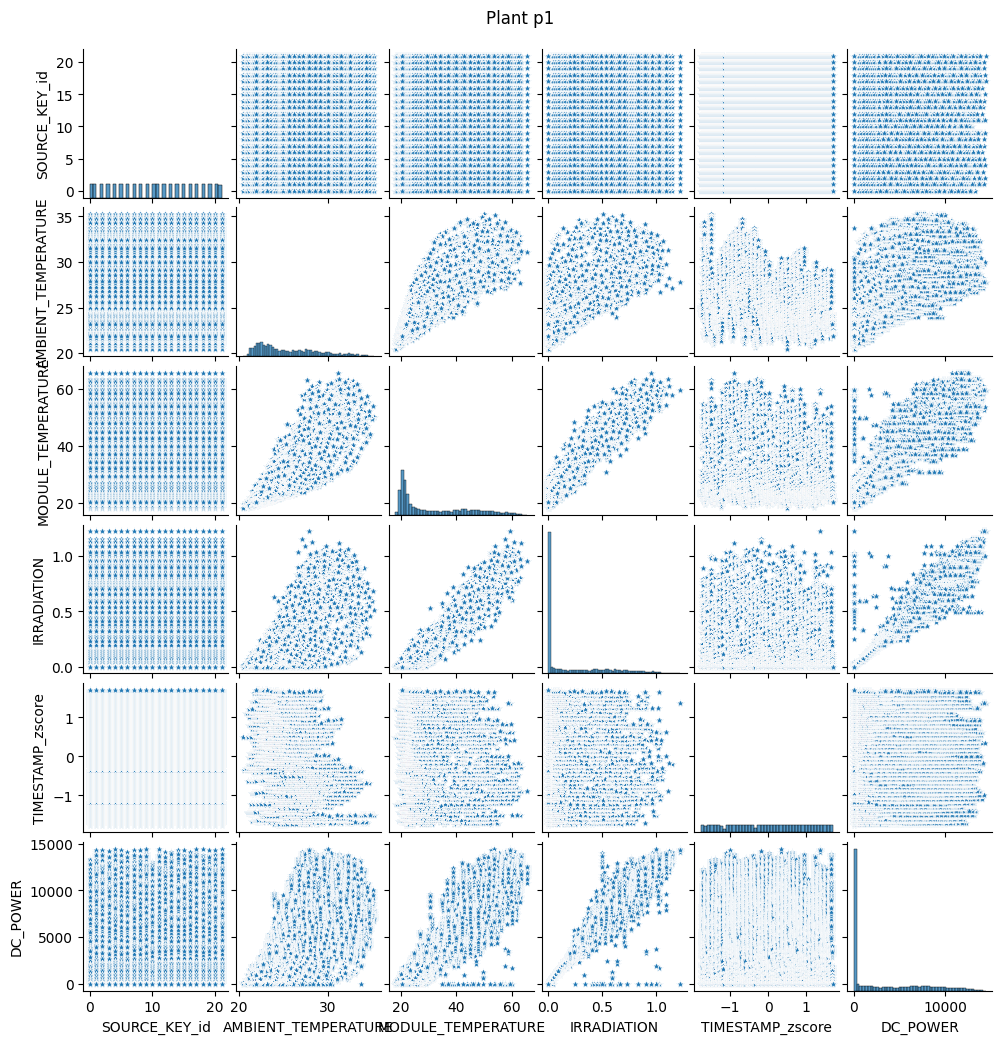

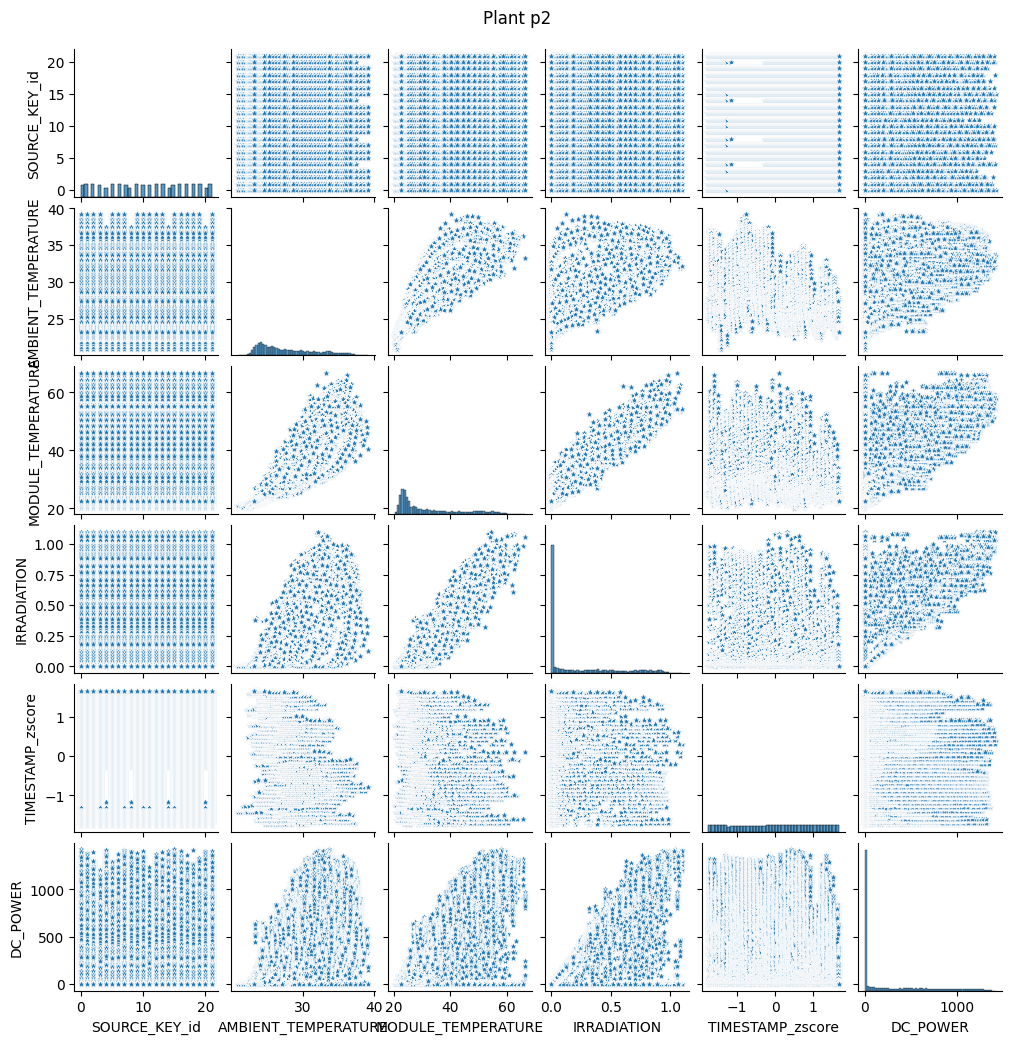

In [8]:
import seaborn as sns

random_seed = 42

x_vars = [
    'SOURCE_KEY_id',
    'AMBIENT_TEMPERATURE',
    'MODULE_TEMPERATURE',
    'IRRADIATION',
    'TIMESTAMP_zscore',
    'DC_POWER',
]

for plant_id, plant_df in sun_data.items():
    pp=sns.pairplot(plant_df[x_vars], markers='*')
    fig_size = pp.fig.get_size_inches()
    pp.fig.set_size_inches(fig_size[0]*2/3, fig_size[1]*2/3)
    pp.fig.suptitle(f"Plant {plant_id}", y=1.025)

We can observe the very low conversion rate for p1 by comparing AC and DC power, about .

p1 shows a nearly linear relationship between irradiation and DC power, in p2 there is a very unpredictable behavior. It seems that plant 2 is frequently producing low DC power output or even none. This could be due to dirty panels or in need of maintenance.

A bit of feature engineering helps us understanding this phenomenon a bit better:
* We created a productivity index that is linearly related to DC power output and inversely related to irradiation.
* Timestamp in integer format allows us to check for temporal dependencies
There does not seem to be any temporal dependecy on p2 productivity.

At this point it seems that p1 may have an inversor problem, while p2 may need cleaning/maintenance.

### Power generation prediction
In day ahead markets, producers would need to set the prices for their contracts with one or several days in advance. We will emulate this situation by creating models for the prediction of 1, 3 and 7 days ahead.
We will use the variables x.x.x of each of the 20 sources, resample the previous two days data into and predict n days ahead.

## Sources
[1] ["Solar Power Generation Data - Kaggle"](https://www.kaggle.com/datasets/anikannal/solar-power-generation-data)